In [5]:
import numpy as np
import pickle
import glob
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import os
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn import *
from sklearn.metrics import *
from sklearn.model_selection import StratifiedKFold
sns.set()
import warnings
warnings.filterwarnings("ignore")
length = 277

In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2009347580193024226
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5803868160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1124147230580070485
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


2024-02-08 12:27:33.287052: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 12:27:33.287111: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 12:27:33.287127: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 12:27:33.287352: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 12:27:33.287363: I tensorflow/core/common_runtime/gpu/gpu

In [7]:
train_values = np.empty(shape=[0, length])
test_values = np.empty(shape=[0, length])

train_beats = glob.glob('./data/train_test/train_beats.csv')
test_beats = glob.glob('./data/train_test/test_beats.csv')

for j in train_beats:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    train_values = np.append(train_values, csvrows, axis=0)

for j in test_beats:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    test_values = np.append(test_values, csvrows, axis=0)
    
print(train_values.shape)
print(test_values.shape)

X_train = train_values[:,:-2]
X_test = test_values[:,:-2]
y_train = train_values[:,-2]
y_test = test_values[:,-2]
X_train1 = X_train.reshape(-1, X_train.shape[1], 1)
X_test1 = X_test.reshape(-1, X_train.shape[1], 1)
y_train1=to_categorical(y_train)
y_test1=to_categorical(y_test)

X = np.concatenate((X_train1, X_test1), axis = 0)
Y = np.concatenate((y_train1, y_test1), axis = 0)


Loading  ./data/train_test/train_beats.csv
Loading  ./data/train_test/test_beats.csv
(31056, 277)
(37442, 277)


In [8]:
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten, Conv1D, MaxPooling1D

def getModel():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=16,padding='same', activation='relu',input_shape=(X_train1.shape[1],X_train1.shape[2])))
    cnnmodel.add(BatchNormalization())
    cnnmodel.add(Conv1D(filters=32, kernel_size=16,padding='same', activation='relu'))
    cnnmodel.add(BatchNormalization())
    cnnmodel.add(Conv1D(filters=9, kernel_size=16,padding='same', activation='relu'))
    cnnmodel.add(MaxPooling1D(pool_size=4,padding='same'))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(256, activation='relu'))
    cnnmodel.add(Dense(128, activation='relu'))
    cnnmodel.add(Dense(32, activation='relu'))
    cnnmodel.add(Dense(9, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    return cnnmodel

cnnmodel = getModel()
cnnmodel.summary()
cnnmodel.fit(X_train1, y_train1, verbose = 0, epochs = 10, validation_split = 0.2, batch_size = 64)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 275, 128)          2176      
                                                                 
 batch_normalization_2 (Bat  (None, 275, 128)          512       
 chNormalization)                                                
                                                                 
 conv1d_4 (Conv1D)           (None, 275, 32)           65568     
                                                                 
 batch_normalization_3 (Bat  (None, 275, 32)           128       
 chNormalization)                                                
                                                                 
 conv1d_5 (Conv1D)           (None, 275, 9)            4617      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 69, 9)            

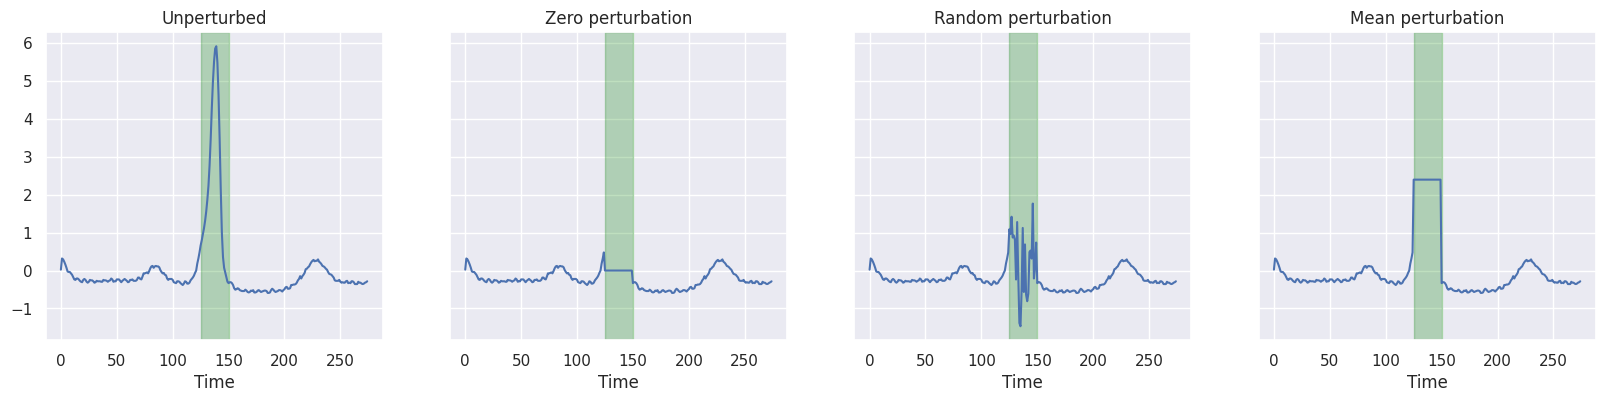

In [9]:
fig, ax = plt.subplots(1, 4, figsize = (20, 4), sharex = True, sharey=True)

ax[0].set_title('Unperturbed')
ax[0].plot(np.arange(len( X[20, :])), X[20, :])

ax[1].set_title('Zero perturbation')
X_zero_perturbed = X[20, :].copy()
X_zero_perturbed[5 * 25 : 6 * 25] = 0.0
ax[1].plot(np.arange(len(X[20, :])), X_zero_perturbed)

ax[2].set_title('Random perturbation')
X_random_perturbed = X[20, :].copy()
X_random_perturbed[5 * 25 : 6 * 25] = np.std(X[20, :]) * np.random.randn(25, 1) + np.mean(X[20, :])
ax[2].plot(np.arange(len(X[20, :])), X_random_perturbed)

ax[3].set_title('Mean perturbation')
X_mean_perturbed = X[20, :].copy()
X_mean_perturbed[5 * 25 : 6 * 25] = np.mean(X[20, 5 * 25 : 6 * 25])
ax[3].plot(np.arange(len(X[20, :])), X_mean_perturbed)

for i in range(4):
    ax[i].set_xlabel('Time')
    ax[i].axvspan(5 * 25, 6 * 25, color = 'green', alpha = 0.25)
fig.savefig('perturbation_methods_ecg_data.jpg', dpi = 400)

66/66 [==============================] - 0s 1ms/step


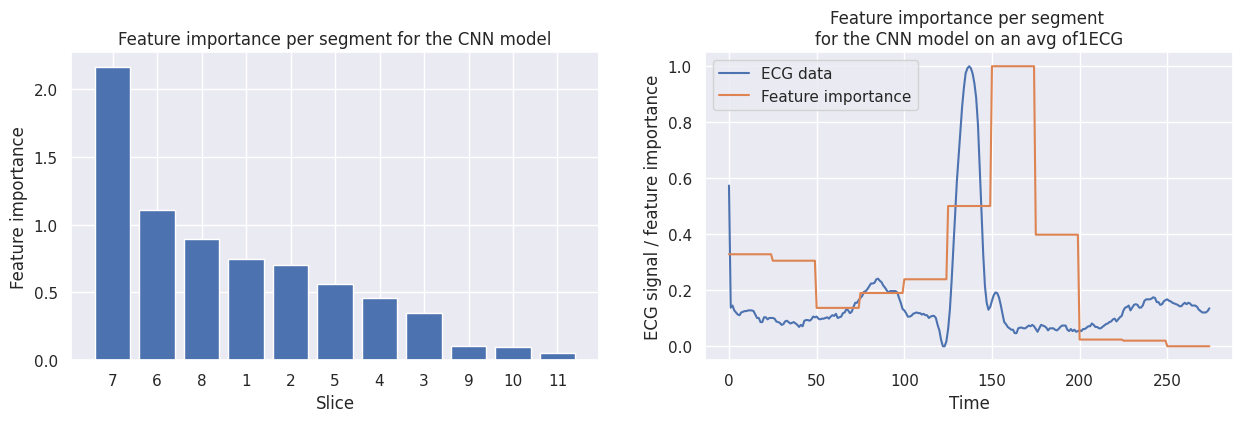

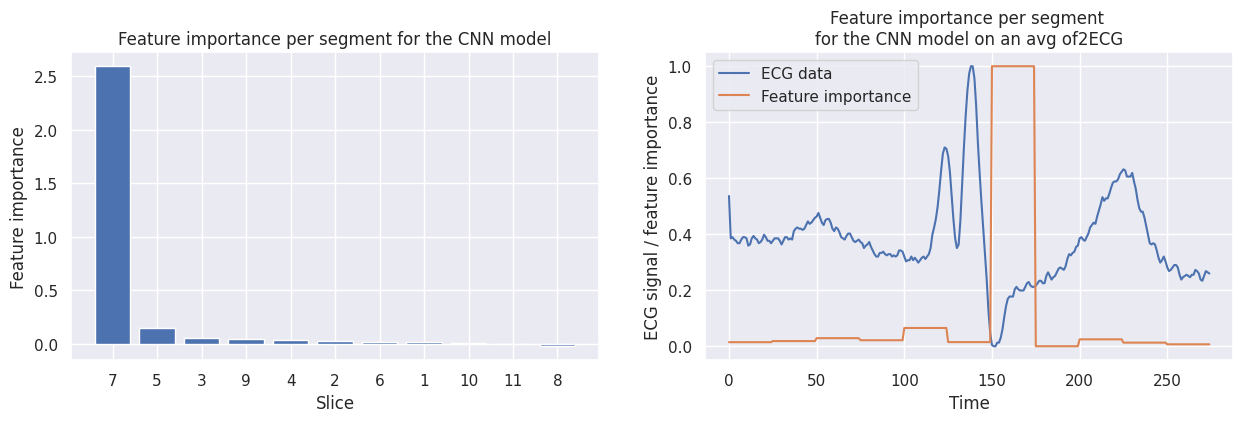

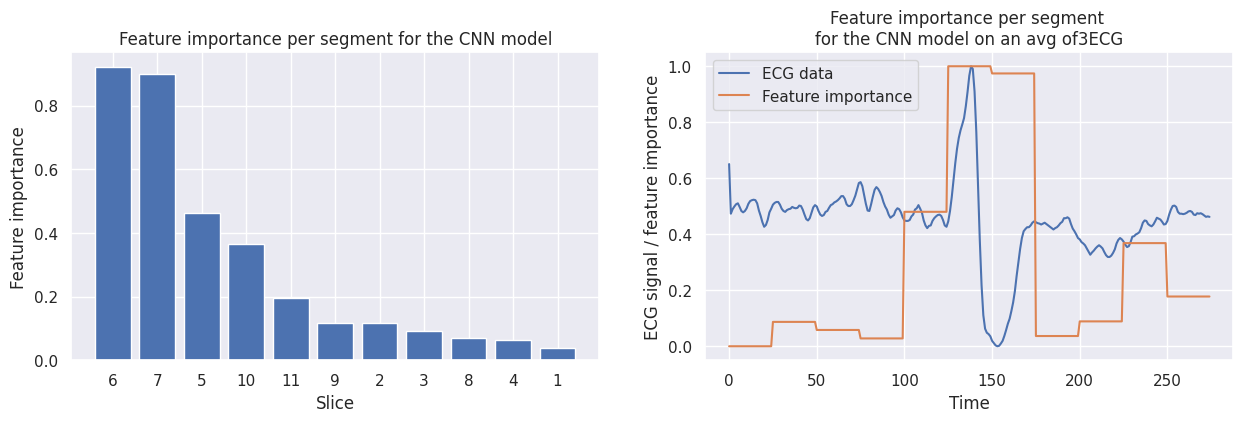

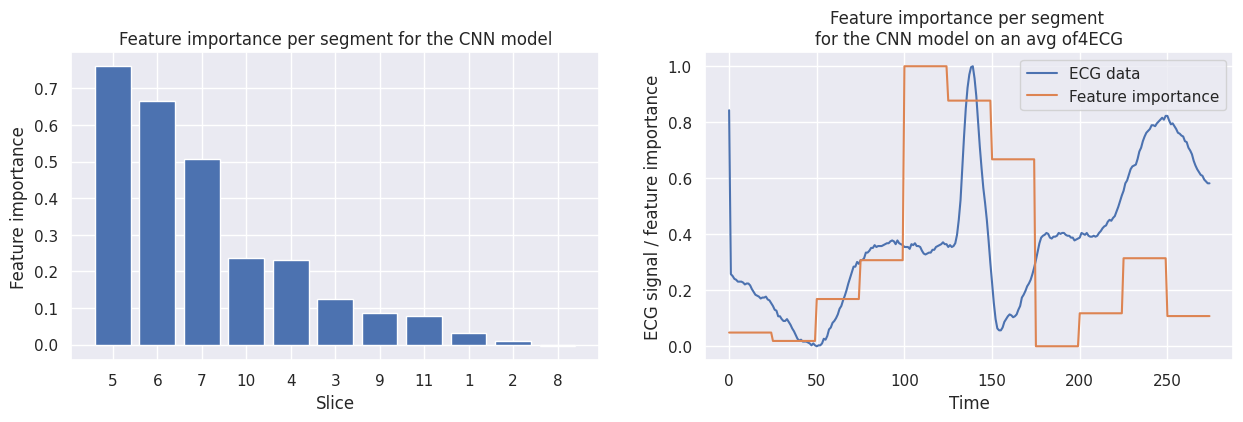

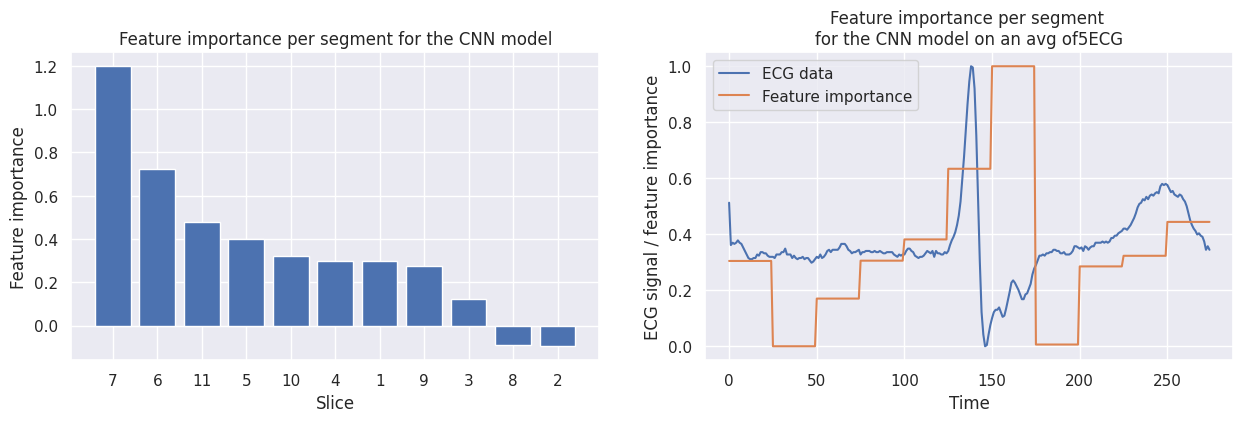

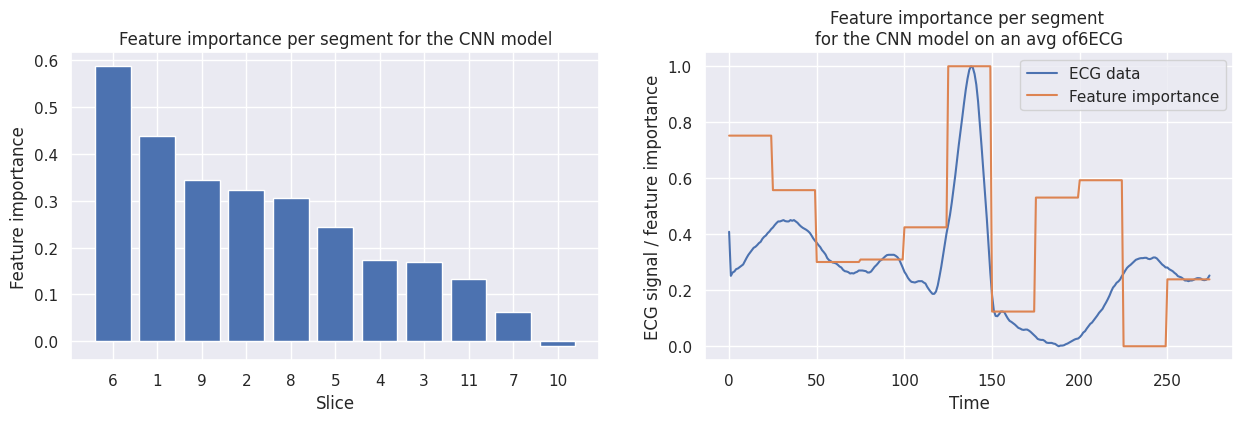

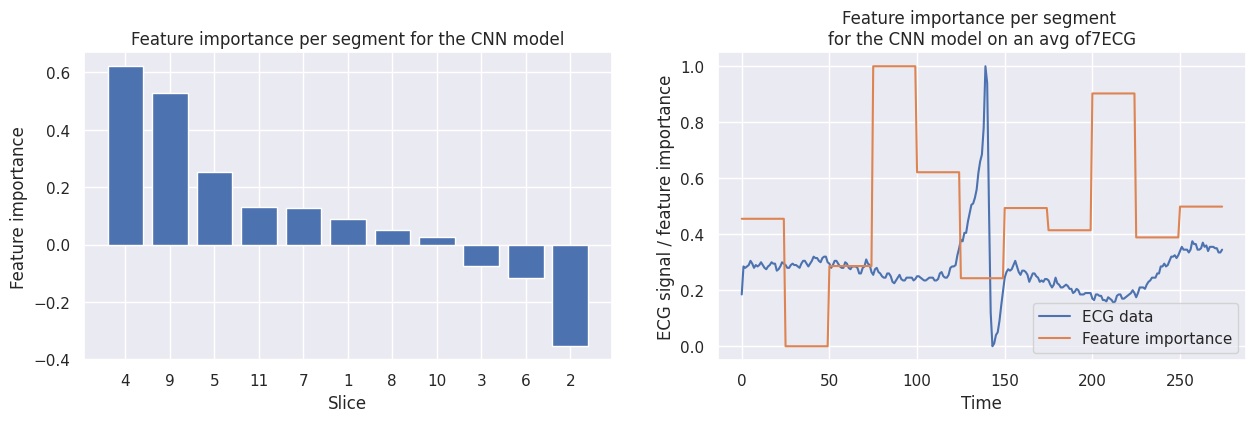

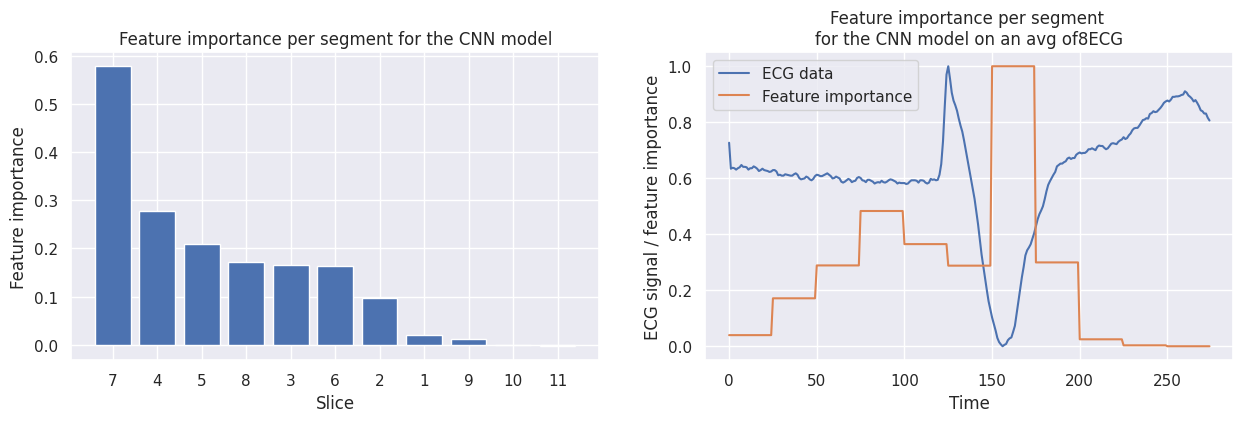

In [11]:
for class_num in range(1, 9):

        N_test = test_values[test_values[:,-2]==class_num]

        Xs_test = N_test[:,:-2]
        ys_test = N_test[:len(N_test),-2]

        Xs_test1 = Xs_test.reshape(-1, X_test.shape[1], 1)
        ys_test1 = to_categorical(ys_test)


        M = np.zeros((Xs_test1.shape[0], 11))

                
        pred_k = cnnmodel.predict(Xs_test1)     
                
    
        for slice_start in range(0, 275, 25):
                x_permuted = np.copy(Xs_test1)
                x_slice = Xs_test1[:, slice_start:slice_start+25]
                x_slice_permuted = np.random.permutation(x_slice)
                x_permuted[:, slice_start:slice_start + 25] = x_slice_permuted
                pred_perm = cnnmodel.predict(x_permuted)
                
                importance = ((np.argmax(ys_test1, axis = 1) - np.argmax(pred_perm, axis = 1))**2 
                                        - (np.argmax(ys_test1, axis = 1) - np.argmax(pred_k, axis = 1))**2)
                M[:, slice_start // 25] = importance    
        mean_importance = np.mean(M, axis = 0)


        indices_sort = np.argsort(-1 * mean_importance)
        slices = np.arange(1, 12)

        fig, ax = plt.subplots(1, 2, figsize = (15, 4))
        ax[0].bar(range(11), mean_importance[indices_sort])
        ax[0].set_title('Feature importance per segment for the CNN model')
        ax[0].set_xticks(np.arange(11))
        ax[0].set_xticklabels(slices[indices_sort].astype(int))
        ax[0].set_xlabel('Slice')
        ax[0].set_ylabel('Feature importance')

        ecg_normalized = (Xs_test[20, :] - Xs_test[20, :].min()) / (Xs_test[20, :].max() - Xs_test[20, :].min())
        feature_importance_normalized = (mean_importance - mean_importance.min()) / (mean_importance.max() - mean_importance.min())
        ax[1].plot(np.arange(len(ecg_normalized)), ecg_normalized, label='ECG data')
        ax[1].plot(np.repeat(feature_importance_normalized, 25), label = 'Feature importance')
        ax[1].set_title('Feature importance per segment \nfor the CNN model on an avg of'+ str(class_num)+ 'ECG')
        ax[1].set_xlabel('Time')
        ax[1].set_ylabel('ECG signal / feature importance')
        ax[1].legend()
        image_name = 'output_pics/cnn_permutation_feature_importance_results' + str(class_num) + '.jpg'
        fig.savefig(image_name, dpi = 400)